# Data

In [ ]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

In [ ]:
!gdown --id 1KZDdua8VBS1MZ7gqQzDkOzo-V_fWTJiW # Downlaod dataset file
!unzip -q Singapore\ dataset.zip              # Unzip it
!rm -rf Singapore\ dataset.zip                # Remove zipped file to save space

Downloading...
From: https://drive.google.com/uc?id=1KZDdua8VBS1MZ7gqQzDkOzo-V_fWTJiW
To: /content/Singapore dataset.zip
100% 119M/119M [00:02<00:00, 52.1MB/s]


## Data Loading and PreProcessing

In [ ]:
train_data = pd.read_csv('Singapore dataset/hdb_train.csv')
print(f'Shape of Train Data is {train_data.shape}')
# train_data.head(10)

Shape of Train Data is (759992, 15)


In [ ]:
# These are utility functions.
def get_asci_of_string(string_data):
  '''
  Replace string with it's ASCII code to convert to numeric value!
  '''
  value = 0 # A varibale to sum up ascii values of entire word
  for char_ in string_data:
    value+=ord(char_) # Ord python function return assci code of given character

  return int(value)


def map_12_to_100(data):
  '''
  Converting hyphon '-' to decimal value.
  e.g. 1999-03 means 1999 and 3rd month. So I will convert it to 1999.25!
  If this is 1999-06, it will be converted to 1999.5!
  If this is 1999-04, it will be converted to 1999.33!
  '''
  data_year  = data.split('-')[0]
  data_month = data.split('-')[1]
  mapped_month = float(data_month) * 8.33
  new_value    = data_year+ '.' + str(int(mapped_month)) # add strings, use . between year and month

  return float(new_value)

def fix_flat_type(data):
  '''
  If entry is from 1-5 return int value of entry
  else if entry is string word, convert to int to.
  '''
  try:
    return int(data)
  except:
    if 'EXECUTIVE' in data:
      return 6
    elif 'MULTI GENERATION' in data:
      return 7
    else:
      exit()

# Code snippet taken from stackoverflow.com
# unused
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [ ]:
def final_preprocessing(data):
  
  # Removing unnecassary columns
  print('\t\t\t***Removing repeating and useless columns***')
  del data['index']
  print('Removed index Column')
  del data['storey_range'] # repeating - Same information is available in floor
  print('Removed storey_range column')
  del data['block'] # didn't adding information in locating price (observation)
  print('Removed block column')
  del data['town'] # Repeatition - same information is available in street_name
  print('Removed town column')
  # Following 3 columns showed less than 0.0 impact on target variable
  print('\t***Removing column that has less then 0.0 impact on target variable! Correlation criteria!***')
  del data['latitude']    # 0.048011
  print('Removed latitude column')
  del data['longitude']   # 0.088065
  print('Removed longitude column')
  del data['postal_code'] # 0.039325
  print('Removed postal_code column')
  del data['street_name'] # This seems to be an important feature, but after extensive experiment it score was less than 0.0, so remiving it! 
  print('Removed street_name column')

  # Convert string to numerics
  print('\t\t\t***Converting String columns to Numeric ones***')
  data['flat_model'] = train_data['flat_model'].apply(lambda x: get_asci_of_string(x))
  print('Column flat_model converted to numeric using asci sums!')
  data['flat_type']  = train_data['flat_type'].apply(lambda x: fix_flat_type(x))
  print('String words replaced with integer ones from flat_model column!')
  data['month']      = train_data['month'].apply(lambda x: map_12_to_100(x))
  print('Inconsistenct removed from month column!')

  # Normalize dataframe
  print('\t\t\t\t***Feature Normalization***')
  if os.path.exists('col_maxes.pt'): # If feature scaling max values are already saved, read them
    print('Reading already saved max values')
    col_maxes = torch.load('col_maxes.pt')
    data = data/col_maxes # feature scaling
  else:
    # otherwise create and save max_values used for feature scaling
    print('Calculating new max values and saving them for feature Normalization')
    col_maxes = train_data.max()
    # Save this max values
    torch.save(col_maxes, 'col_maxes.pt') # module to save tensors
    data = data/col_maxes # feature scaling

  return data

train_data = final_preprocessing(train_data)
print(f'Shape of Train Data is {train_data.shape}')
train_data.head(10)

			***Removing repeating and useless columns***
Removed index Column
Removed storey_range column
Removed block column
Removed town column
	***Removing column that has less then 0.0 impact on target variable! Correlation criteria!***
Removed latitude column
Removed longitude column
Removed postal_code column
Removed street_name column
			***Converting String columns to Numeric ones***
Column flat_model converted to numeric using asci sums!
String words replaced with integer ones from flat_model column!
Inconsistenct removed from month column!
				***Feature Normalization***
Reading already saved max values
Shape of Train Data is (759992, 7)


,flat_model,flat_type,floor_area_sqm,lease_commence_date,month,resale_price,floor
0,0.38375,0.142857,0.100977,0.981141,0.986619,0.007627,0.22
1,0.38375,0.142857,0.100977,0.981141,0.986619,0.005085,0.10
2,0.38375,0.142857,0.100977,0.981141,0.986619,0.006780,0.22
3,0.38375,0.142857,0.100977,0.981141,0.986619,0.005085,0.16
4,0.63375,0.428571,0.237785,0.980645,0.986619,0.040000,0.10
5,0.63375,0.428571,0.218241,0.981141,0.986619,0.038983,0.04
6,0.63375,0.428571,0.218241,0.981141,0.986619,0.035593,0.16
7,0.63375,0.428571,0.218241,0.981141,0.986619,0.032203,0.22
8,0.63375,0.428571,0.218241,0.981141,0.986619,0.033898,0.10
9,0.63375,0.428571,0.218241,0.981141,0.986619,0.039831,0.04


## Analysis

In [ ]:
# make sure datatype of all column is now some numeric value
for col_name in train_data:
  print(train_data[col_name].dtype)

float64
float64
float64
float64
float64
float64
float64


Uniques values inside Town variable: 27


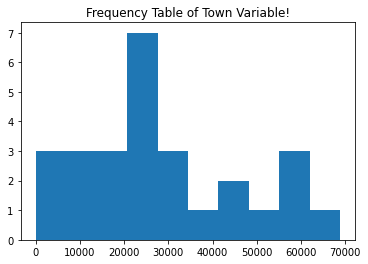

Frequency Table
TAMPINES           68837
YISHUN             58645
BEDOK              57730
JURONG WEST        55913
WOODLANDS          53859
ANG MO KIO         45402
HOUGANG            42382
BUKIT BATOK        37694
CHOA CHU KANG      30641
PASIR RIS          28312
BUKIT MERAH        27912
TOA PAYOH          26217
CLEMENTI           24310
GEYLANG            24215
QUEENSTOWN         23827
KALLANG/WHAMPOA    22211
BUKIT PANJANG      21542
JURONG EAST        21355
SERANGOON          19865
SENGKANG           18569
BISHAN             18318
SEMBAWANG           9309
PUNGGOL             8144
MARINE PARADE       7031
CENTRAL AREA        5578
BUKIT TIMAH         2110
LIM CHU KANG          64
Name: town, dtype: int64


In [ ]:
# Analysing Town Variable
town = train_data['town'].value_counts() # generate frequency tabble
print(f'Uniques values inside Town variable: {len(town)}')
plt.hist(town); plt.title('Frequency Table of Town Variable!'); plt.show() # plot frequency table
print(f'Frequency Table\n{town}')

Uniques values inside Street Name variable: 542


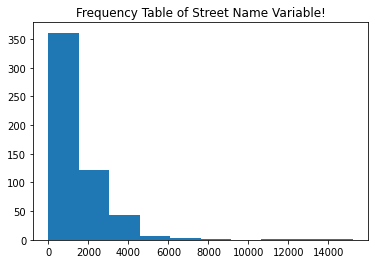

Frequency Table
YISHUN RING RD        15217
BEDOK RESERVOIR RD    12973
ANG MO KIO AVE 10     12287
ANG MO KIO AVE 3      10769
HOUGANG AVE 8          8194
                      ...  
GEYLANG EAST AVE 2       13
SEMBAWANG WAY            10
OUTRAM HILL               9
PUNGGOL WALK              4
MARINE PARADE CTRL        2
Name: street_name, Length: 542, dtype: int64


In [ ]:
# Analyzing Street address
street_name = train_data['street_name'].value_counts() # generate frequency tabble
print(f'Uniques values inside Street Name variable: {len(street_name)}')
plt.hist(street_name); plt.title('Frequency Table of Street Name Variable!'); plt.show() # plot it
print(f'Frequency Table\n{street_name}')

Uniques values inside Month variable: 333


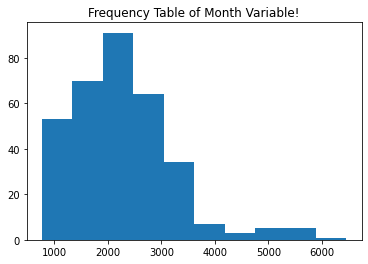

Frequency Table
1999.24    6457
1999.49    5852
1998.83    5689
1999.33    5673
1999.41    5657
           ... 
1991.49     831
1991.16     816
1990.83     811
1990.49     810
1990.41     768
Name: month, Length: 333, dtype: int64


In [ ]:
# Analyzing Month address
month = train_data['month'].value_counts() # generate frequency tabble
print(f'Uniques values inside Month variable: {len(month)}')
plt.hist(month); plt.title('Frequency Table of Month Variable!'); plt.show() # plot it
print(f'Frequency Table\n{month}')

Uniques values inside Flat Model variable: 20


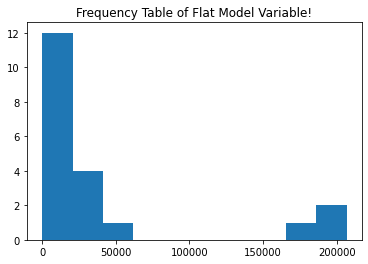

Frequency Table
466     206670
614     200096
1014    167960
742      51321
593      37531
684      29339
1259     28147
761      24950
516       8296
901       1880
1272      1773
518        604
300        491
1175       466
486        173
1420       104
487         74
1336        74
412         38
1600         5
Name: flat_model, dtype: int64


In [ ]:
# Analysing Flat Model and Flat Type Variable
flat_model = train_data['flat_model'].value_counts() # generate frequency tabble
print(f'Uniques values inside Flat Model variable: {len(flat_model)}')
plt.hist(flat_model); plt.title('Frequency Table of Flat Model Variable!'); plt.show() # plot it
print(f'Frequency Table\n{flat_model}')

Uniques values inside Flat Model variable: 7


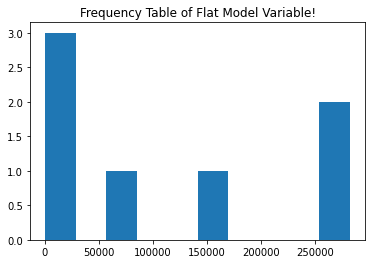

Frequency Table
4                   282423
3                   255151
5                   154655
EXECUTIVE            57612
2                     8441
1                     1244
MULTI GENERATION       466
Name: flat_type, dtype: int64


In [ ]:
# Analysing Flat Type Variable
flat_type = train_data['flat_type'].value_counts() # generate frequency tabble
print(f'Uniques values inside Flat Model variable: {len(flat_type)}')
plt.hist(flat_type); plt.title('Frequency Table of Flat Model Variable!'); plt.show() # plot it
print(f'Frequency Table\n{flat_type}')

flat_model            -0.097013
flat_type              0.657249
floor_area_sqm         0.642275
lease_commence_date    0.486772
month                  0.585892
resale_price           1.000000
latitude               0.048011
longitude              0.088065
postal_code            0.039325
floor                  0.183010
dtype: float64


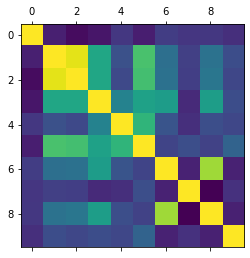

In [ ]:
# Find statistical correlation matrix with reference to target variable 
corr_matrix = train_data.corrwith(train_data["resale_price"])
print(corr_matrix)
plt.matshow(train_data.corr()); # plot it

flat_model            -0.097013
flat_type              0.657249
floor_area_sqm         0.642275
lease_commence_date    0.486772
month                  0.585892
resale_price           1.000000
street_name            0.015636
floor                  0.183010
dtype: float64


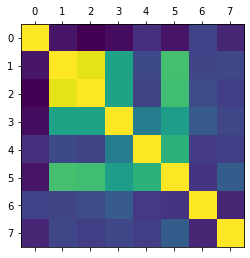

In [ ]:
# Correlation taken after converting street num to asci codes
corr_matrix = train_data.corrwith(train_data["resale_price"])
print(corr_matrix)
plt.matshow(train_data.corr()); 

In [ ]:
# Correlation taken after converting street num to one-hot-encoded vector
corr = train_data.corr()
corr.style.background_gradient(cmap='coolwarm')
corr['resale_price'].tolist()

[-0.0970127769545628,
 0.6572489065905113,
 0.6422753135636026,
 0.48677171532793434,
 0.5858919573992271,
 1.0,
 0.1830099066050373,
 0.029432109186426213,
 0.014648239451637646,
 0.012885168174074537,
 -0.010282185955834477,
 -0.02652177560112196,
 0.010687073802903428,
 0.023158535342135893,
 0.01713878535199724,
 0.032593984806058594,
 0.03402048696839944,
 -0.0352846773868941,
 -0.05733092295221626,
 -0.002371973693289485,
 -0.05141215215337339,
 -0.04309526393861212,
 -0.04155112119675295,
 -0.004423186502556635,
 -0.023016290864709223,
 -0.004202564037539714,
 0.016333721050060486,
 0.014842813610159326,
 0.037447114623197796,
 0.029771564826295716,
 0.042741623801958326,
 0.012189393327841018,
 -0.03015408278190963,
 -0.009286071884861972,
 -0.008805977248685678,
 0.033998878828532704,
 -0.028623389837859725,
 -0.007702967893530415,
 0.00027105012450762356,
 -0.00851790304549515,
 -0.03658426830635932,
 -0.02453004083562775,
 -0.024595309387723894,
 -0.0660808393238305,
 -0.007

flat_model            -0.097013
flat_type              0.657249
floor_area_sqm         0.642275
lease_commence_date    0.486772
month                  0.585892
resale_price           1.000000
floor                  0.183010
dtype: float64


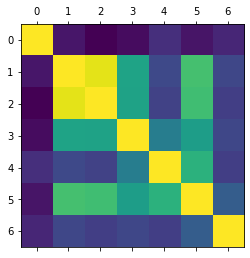

In [ ]:
corr_matrix = train_data.corrwith(train_data["resale_price"])
print(corr_matrix)
plt.matshow(train_data.corr()); 

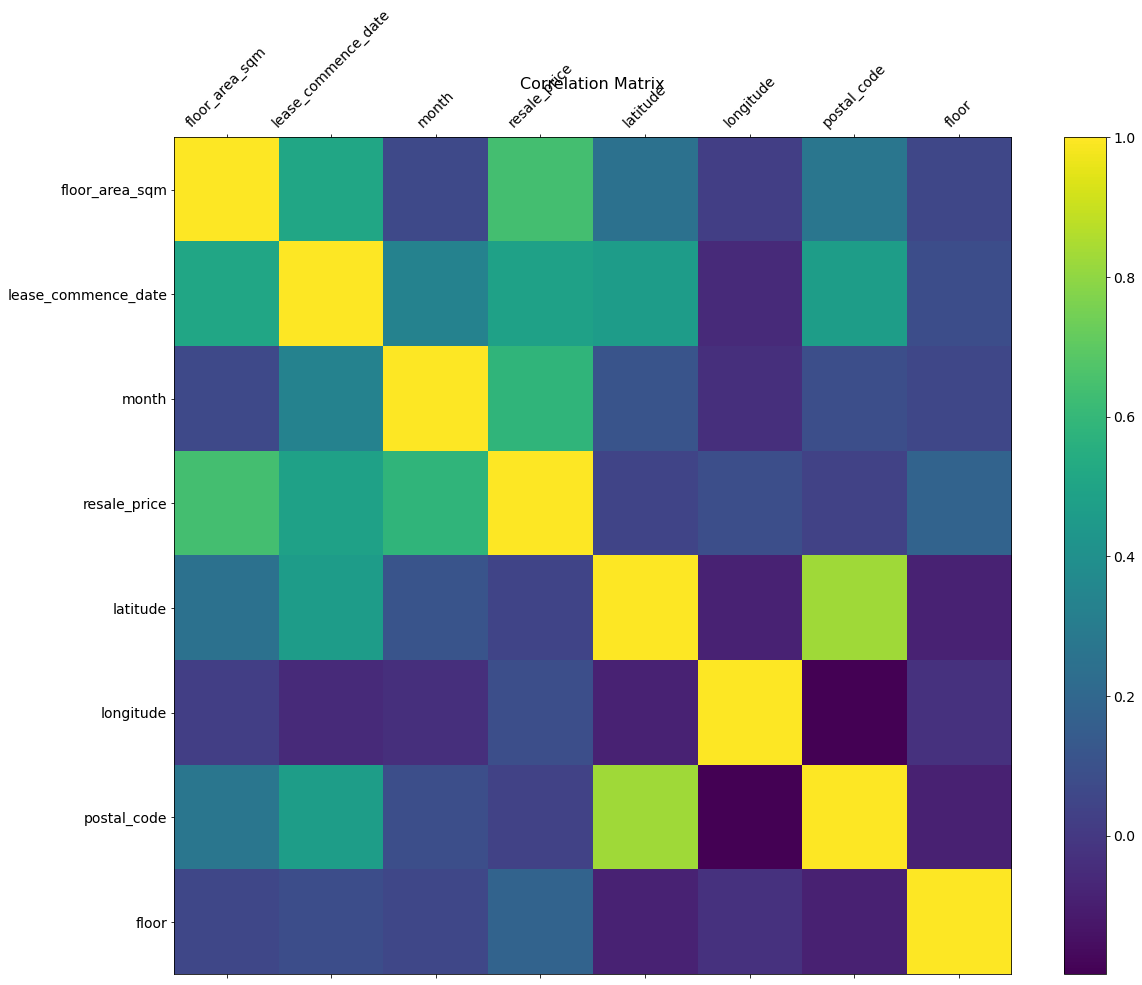

In [ ]:
# A more optimal view of correlation matrix.
# Code snippet taken from stackover flow
df = train_data
f = plt.figure(figsize=(19, 15))
plt.matshow(df.corr(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=45)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

# Data Train/Test Split, DataClass, DataLoader

In [ ]:
train, test = train_test_split(train_data, test_size = 0.5, random_state=10000) # split data between train and test

In [ ]:
# Create a dataset class
class HousePricePredictionDataset(Dataset):
  def __init__(self, data_frame):
    super().__init__()
    self.data_frame = data_frame # pass pandas data frame to local variable of class

  def __len__(self):
    return len(self.data_frame)

  def __getitem__(self, index):
    if torch.is_tensor(index):
      index = index.tolist()
    requested_data = self.data_frame.iloc[index]               # get indexed row from dataframe
    features = requested_data.drop('resale_price')             # sperate target variable from entire data
    target   = requested_data['resale_price']                  # Store target variable too as label
    features = torch.tensor(features.to_numpy().reshape(1, -1))# reshape and convert it to 1 channel
    # print(features.dtype)
    return features, target

# create train-test classes
train_class  = HousePricePredictionDataset(data_frame=train)
test_class   = HousePricePredictionDataset(data_frame=test)


In [ ]:
# Hyper Parameteres
BATCH_SIZE = 2048; BATCH = 0
TOTAL_DATAPOINTS = train_class.__len__()
print(f'Total Data Points fonud : {TOTAL_DATAPOINTS}')
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
EPOCHS = 20; EPOCH_LOSS = []
LR = 0.0001

ITER_PER_EPOCH = int(TOTAL_DATAPOINTS / BATCH_SIZE)
MAX_BATCH = ITER_PER_EPOCH * EPOCHS
print(f'Total Iter: {MAX_BATCH} in {EPOCHS} Epochs with Batch Size {BATCH_SIZE} and {ITER_PER_EPOCH} iter per Epoch!')
col_maxes = torch.load('col_maxes.pt')
print(f'Multiplication Scalar with output file is {col_maxes.resale_price}')

Total Data Points fonud : 379996
Total Iter: 3700 in 20 Epochs with Batch Size 2048 and 185 iter per Epoch!
Multiplication Scalar with output file is 1180000.0


In [ ]:
# Create train-test data loader that will feed data to model for training and testing using
# pytoch built-in data loader class
train_loader = DataLoader(train_class, BATCH_SIZE, True, drop_last=True)
test_loader  = DataLoader(test_class, BATCH_SIZE*2, True, drop_last=True)

# Model Class and Hyper-Parameters

In [ ]:
class RegressionUsingCNN(nn.Module):
  def __init__(self):
    super(RegressionUsingCNN, self).__init__()

    self.learner_channels = 128 
    self.classifier_channels = 1408 # This name was typed mistakenly, it should be regressor. DON'T Change it now.
    # Feature Learning Layers
    # 5 Convolutional layers for extracting features out of data
    self.learner = nn.Sequential(
        
        # First layer that will receive input
        # apply 128 filters on it and return 128 channel output to next layer
        # each layers is being followed by normalization layer and relu activation function
        nn.Conv1d(1, self.learner_channels, 1),
        nn.BatchNorm1d(self.learner_channels),
        nn.ReLU(),

        # Second layer, receive results of previous layer with 128 channels
        # Apply 256 kernel and returns output in 256 channels
        # To prevent reduction of lateral size, apply padding of kernel_size-1 integer
        nn.Conv1d(self.learner_channels, self.learner_channels*2, 3, padding=2),
        nn.BatchNorm1d(self.learner_channels*2),
        nn.ReLU(),

        # Third layer, 256 input channel and 512 output channels
        nn.Conv1d(self.learner_channels*2, self.learner_channels*4, 4, padding=3),
        nn.BatchNorm1d(self.learner_channels*4),
        nn.ReLU(),

        # Fourth Convolutional Layer - 512 input channels and 256 output
        # No need of padding as we have kernel size of 1
        nn.Conv1d(self.learner_channels*4, self.learner_channels*2, 1),
        nn.BatchNorm1d(self.learner_channels*2),
        nn.ReLU(),

        # Fifth one - 256 input and 128 out channels
        nn.Conv1d(self.learner_channels*2, self.learner_channels, 1),
        nn.BatchNorm1d(self.learner_channels),
        nn.ReLU(),
    )


    # regressoion Layer
    # These FC layers will help model in predicting regression value
    # this name was settled mistakenly. It's just a variable name, it should be named as regressor.
    # But now we can't change it. As best saved model will try to find this named layers when being loaded.
    self.classifier = nn.Sequential(
        # First FC layer
        # Downsampling to bring 1408 value to 1 for getting price
        nn.Linear(self.classifier_channels, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),

        # Second FC Layer
        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),        

        # Third FC
        nn.Linear(256, 8),
        nn.BatchNorm1d(8),
        nn.ReLU(),

        # Fourth FC
        # Regressor output
        nn.Linear(8, 1)
    )


  def forward(self, x):
    x = self.learner(x) # Pass input data to convolutional layers
    x = x.view(x.shape[0], x.shape[1]*x.shape[2]) # Flatten output to feed it to FC layers
    x = self.classifier(x) # Pass to regression layers
    # x = x.view(-1, 1)
    return x

model = RegressionUsingCNN().to(DEVICE)
summary(model, (1,6))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1               [-1, 128, 6]             256
       BatchNorm1d-2               [-1, 128, 6]             256
              ReLU-3               [-1, 128, 6]               0
            Conv1d-4               [-1, 256, 8]          98,560
       BatchNorm1d-5               [-1, 256, 8]             512
              ReLU-6               [-1, 256, 8]               0
            Conv1d-7              [-1, 512, 11]         524,800
       BatchNorm1d-8              [-1, 512, 11]           1,024
              ReLU-9              [-1, 512, 11]               0
           Conv1d-10              [-1, 256, 11]         131,328
      BatchNorm1d-11              [-1, 256, 11]             512
             ReLU-12              [-1, 256, 11]               0
           Conv1d-13              [-1, 128, 11]          32,896
      BatchNorm1d-14              [-1, 

In [ ]:
# Testing Model
# x, y = next(iter(train_loader))
# model = RegressionUsingCNN()
# model = model.float()
# y_ = model(x.float())


In [ ]:
loss_fn = nn.MSELoss() # Difine Loss Function
optim   = torch.optim.SGD(model.parameters(), lr=LR) # Generate Optimizer
# ii = loss(torch.tensor(2.0), torch.tensor(10.0))
# ii = torch.sqrt(ii)
# ii.item()


# Training

Test Data Loss: 0.12209147214889526
Test Data Loss: 0.10165704786777496
Test Data Loss: 0.08732308447360992
Test Data Loss: 0.074381023645401
Test Data Loss: 0.06437396258115768


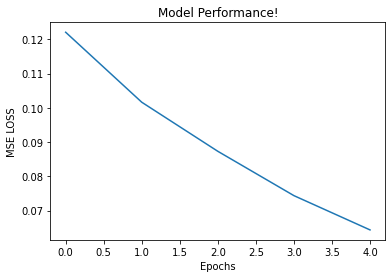

Test Data Loss: 0.05614195019006729
Test Data Loss: 0.04872465506196022
Test Data Loss: 0.04297807067632675
Test Data Loss: 0.0375077985227108
Test Data Loss: 0.03251614794135094


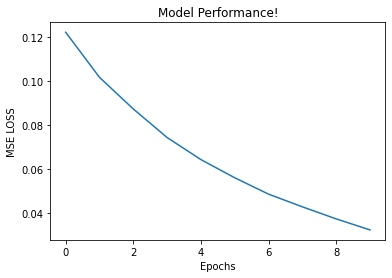

Test Data Loss: 0.02910352125763893
Test Data Loss: 0.025471782311797142
Test Data Loss: 0.023153673857450485
Test Data Loss: 0.02086024358868599
Test Data Loss: 0.018843214958906174


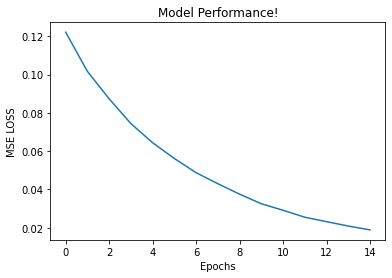

Test Data Loss: 0.016936203464865685
Test Data Loss: 0.015489071607589722
Test Data Loss: 0.013968050479888916
Test Data Loss: 0.012782944366335869
Test Data Loss: 0.011859540827572346


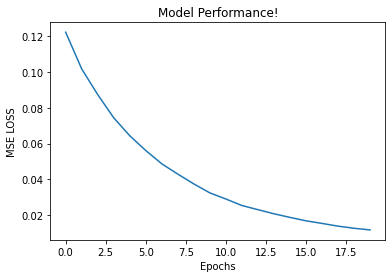

In [ ]:
# data, target = next(iter(test_loader))
model.train()
for EPOCH in range(EPOCHS): # Run for 20 Epochs
  for ITER, (data, target) in enumerate(train_loader):
    optim.zero_grad()
    predictions = model(data.float().to(DEVICE)) # get predictions form model
    target = target.view_as(predictions)         # Reshape them
    loss = loss_fn(predictions, target.float().to(DEVICE)) # Calculate loss
    # print(loss.item(), loss.dtype)
    loss.float().backward() # Launch backpropagation on loss
    optim.step() # Change derivatives
  
  # Print Evaluatoin Log after each EPOCH
  model.eval() # Invoke evaluation mode of model
  local_eval_loss = [] # List to store loss of each validation batch 
  for valiter, (valdata, valtarget) in enumerate(test_loader):
    if valiter == 20: # For sampling, just pass 20 batchs, it will save time
      break
    valpred = model(valdata.float().to(DEVICE))
    valtarget = valtarget.view_as(valpred)
    valloss = loss_fn(valpred, valtarget.float().to(DEVICE))
    local_eval_loss.append(valloss.item())
  EPOCH_LOSS.append(torch.mean(torch.tensor(local_eval_loss, dtype=torch.float))) # Take mean of 20 batchs loss
  print(f'Test Data Loss: {EPOCH_LOSS[-1]}')
  model.train() # Invoke training mode of model again

  if (EPOCH+1) % 5 == 0: # Plot the Evaluation (unseen data loss) each 5 epoch
    plt.plot(EPOCH_LOSS)
    plt.xlabel('Epochs'); plt.ylabel('MSE LOSS')
    plt.title('Model Performance!')
    plt.show()
  

In [ ]:
torch.save(model.state_dict(), 'best_model.pth') # save the model at end

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive/')
# %cd /content/gdrive/MyDrive/
# !cp /content/best_model.pth .
# !cp /content/col_maxes.pt .

# Inference

In [1]:
import os

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
# from sklearn.model_selection import KFold

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary

!gdown --id 1KZDdua8VBS1MZ7gqQzDkOzo-V_fWTJiW 
!unzip -q Singapore\ dataset.zip              
!rm -rf Singapore\ dataset.zip                

data = pd.read_csv('Singapore dataset/hdb_train.csv')
_, test_data = train_test_split(data, test_size = 0.5, random_state=10000)
print(f'Shape of Test Data is {test_data.shape}')

def get_asci_of_string(string_data):
  '''
  Replace string with it's ASCII code to convert to numeric value!
  '''
  value = 0
  for char_ in string_data:
    value+=ord(char_)

  return int(value)


def map_12_to_100(data):
  '''
  Converting hyphon '-' to decimal value.
  e.g. 1999-03 means 1999 and 3rd month. So I will convert it to 1999.25!
  If this is 1999-06, it will be converted to 1999.5!
  If this is 1999-04, it will be converted to 1999.33!
  '''
  data_year  = data.split('-')[0]
  data_month = data.split('-')[1]
  mapped_month = float(data_month) * 8.33
  new_value    = data_year+ '.' + str(int(mapped_month))

  return float(new_value)

def fix_flat_type(data):
  '''
  If entry is from 1-5 return int value of entry
  else if entry is string word, convert to int to.
  '''
  try:
    return int(data)
  except:
    if 'EXECUTIVE' in data:
      return 6
    elif 'MULTI GENERATION' in data:
      return 7
    else:
      exit()

# Code snippet taken from stackoverflow.com
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

def read_normalized_values():
  col_maxes = None
  if os.path.exists('col_maxes.pt'):
    print('Reading already saved max values')
  else:
    # Download max value variable
    !gdown --id 1XpYpzdRH6kVGjhY0HrJSzjY0uDUN4Nuj
    col_maxes = torch.load('col_maxes.pt')
  return col_maxes


def final_preprocessing(data, col_maxes):
  
  # Removing unnecassary columns
  print('\t\t\t***Removing repeating and useless columns***')
  del data['index']
  print('Removed index Column')
  del data['storey_range'] # repeating - Same information is available in floor
  print('Removed storey_range column')
  del data['block'] # didn't adding information in locating price (observation)
  print('Removed block column')
  del data['town'] # Repeatition - same information is available in street_name
  print('Removed town column')
  # Following 3 columns showed less than 0.0 impact on target variable
  print('\t***Removing column that has less then 0.0 impact on target variable! Correlation criteria!***')
  del data['latitude']    # 0.048011
  print('Removed latitude column')
  del data['longitude']   # 0.088065
  print('Removed longitude column')
  del data['postal_code'] # 0.039325
  print('Removed postal_code column')
  del data['street_name'] # This seems to be an important feature, but after extensive experiment it score was less than 0.0, so remiving it! 
  print('Removed street_name column')

  # Convert string to numerics
  print('\t\t\t***Converting String columns to Numeric ones***')
  data['flat_model'] = data['flat_model'].apply(lambda x: get_asci_of_string(x))
  print('Column flat_model converted to numeric using asci sums!')
  data['flat_type']  = data['flat_type'].apply(lambda x: fix_flat_type(x))
  print('String words replaced with integer ones from flat_model column!')
  data['month']      = data['month'].apply(lambda x: map_12_to_100(x))
  print('Inconsistenct removed from month column!')

  # Normalize dataframe
  print('\t\t\t\t***Feature Normalization***')
  data = data/col_maxes

  return data

col_maxes = read_normalized_values()
test_data = final_preprocessing(test_data, col_maxes)
print(f'Shape of Test Data is {test_data.shape}')


class HousePricePredictionDataset(Dataset):
  def __init__(self, data_frame):
    super().__init__()
    self.data_frame = data_frame

  def __len__(self):
    return len(self.data_frame)

  def __getitem__(self, index):
    if torch.is_tensor(index):
      index = index.tolist()
    requested_data = self.data_frame.iloc[index]
    features = requested_data.drop('resale_price')
    target   = requested_data['resale_price']
    features = torch.tensor(features.to_numpy().reshape(1, -1))

    return features, target

test_class   = HousePricePredictionDataset(data_frame=test_data)
test_loader  = DataLoader(test_class, 512, True, drop_last=True)

class RegressionUsingCNN(nn.Module):
  def __init__(self):
    super(RegressionUsingCNN, self).__init__()

    self.learner_channels = 128
    self.classifier_channels = 1408
    # Feature Learning Layers
    self.learner = nn.Sequential(
        nn.Conv1d(1, self.learner_channels, 1),
        nn.BatchNorm1d(self.learner_channels),
        nn.ReLU(),

        nn.Conv1d(self.learner_channels, self.learner_channels*2, 3, padding=2),
        nn.BatchNorm1d(self.learner_channels*2),
        nn.ReLU(),

        nn.Conv1d(self.learner_channels*2, self.learner_channels*4, 4, padding=3),
        nn.BatchNorm1d(self.learner_channels*4),
        nn.ReLU(),

        nn.Conv1d(self.learner_channels*4, self.learner_channels*2, 1),
        nn.BatchNorm1d(self.learner_channels*2),
        nn.ReLU(),

        nn.Conv1d(self.learner_channels*2, self.learner_channels, 1),
        nn.BatchNorm1d(self.learner_channels),
        nn.ReLU(),
    )


    # Classification Layer
    self.classifier = nn.Sequential(
        nn.Linear(self.classifier_channels, 512),
        nn.BatchNorm1d(512),
        nn.ReLU(),

        nn.Linear(512, 256),
        nn.BatchNorm1d(256),
        nn.ReLU(),        

        nn.Linear(256, 8),
        nn.BatchNorm1d(8),
        nn.ReLU(),

        nn.Linear(8, 1)
    )
    # self.double()


  def forward(self, x):
    x = self.learner(x)
    x = x.view(x.shape[0], x.shape[1]*x.shape[2])
    x = self.classifier(x)
    # x = x.view(-1, 1)
    return x

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = RegressionUsingCNN().to(DEVICE)
summary(model, (1,6))
print(f'Model Initialized!')

# Download best_model.pth from google drive
!gdown --id 1ydVGuucZoTDrJ02s2MHsBnMZC8lcg5-J
model.load_state_dict(torch.load('best_model.pth'))
print('Best Saved Model is loaded!')

model.eval()
collective_predictions = []
for testiter, (testdata, testtarget) in enumerate(test_loader):
  if testiter == 20:
    break
  testpred = model(testdata.float().to(DEVICE))
  collective_predictions.append(testpred*col_maxes['resale_price'])

print(f'Regression Values Predicted for given Data!')

Downloading...
From: https://drive.google.com/uc?id=1KZDdua8VBS1MZ7gqQzDkOzo-V_fWTJiW
To: /content/Singapore dataset.zip
100% 119M/119M [00:00<00:00, 161MB/s]
Shape of Train Data is (379996, 15)
Downloading...
From: https://drive.google.com/uc?id=1XpYpzdRH6kVGjhY0HrJSzjY0uDUN4Nuj
To: /content/col_maxes.pt
100% 1.33k/1.33k [00:00<00:00, 2.19MB/s]
			***Removing repeating and useless columns***
Removed index Column
Removed storey_range column
Removed block column
Removed town column
	***Removing column that has less then 0.0 impact on target variable! Correlation criteria!***
Removed latitude column
Removed longitude column
Removed postal_code column
Removed street_name column
			***Converting String columns to Numeric ones***
Column flat_model converted to numeric using asci sums!
String words replaced with integer ones from flat_model column!
Inconsistenct removed from month column!
				***Feature Normalization***
Shape of Test Data is (379996, 7)
--------------------------------------

In [2]:
print(f'Test Data Predictions:\n{collective_predictions}')

Test Data Predictions:
[tensor([[209122.1406],
        [  4143.9961],
        [100364.1875],
        [177433.5312],
        [193231.3438],
        [295053.6562],
        [235668.5156],
        [307838.4062],
        [100605.7109],
        [158783.2031],
        [183893.4375],
        [223123.6250],
        [189140.8906],
        [139755.0781],
        [135769.7656],
        [305305.4688],
        [271248.9062],
        [204388.4062],
        [293560.8438],
        [280021.9062],
        [356405.6875],
        [363631.4062],
        [ 68206.6875],
        [223472.2812],
        [318546.8125],
        [  1552.5061],
        [231450.7969],
        [204179.3438],
        [289820.5938],
        [381237.5625],
        [310284.6562],
        [ 88757.5312],
        [ 29881.7949],
        [ 85730.8125],
        [382339.6875],
        [164351.9844],
        [206818.7812],
        [404298.7188],
        [234860.3125],
        [198480.6406],
        [312575.9062],
        [ 87581.6406],
        [ 

# Report

#### Dataset
Given Data has two modes availabel. One is Private and other HDB. Both HDB and Private has it's own distributions of train and test splits. We are using HDB dataset for this current experiment.

#### Analysis and Feature Engineering
Initially we had 15 features, some of them were useless and some of them were repeating columns. I had removed them.


Machine Learning models expect data to be in numeric format. So for this purpose, we needed to convert our those columns to numeric ones that had string values. We adopted some strategies to convert string to numeric ones. e.g. flat_model converted string data into numeric using ASCII sums, for flat_type I used ordinal coding. Month had a '-' in it and it was like 1999-06, so I mapped 12 values of months into 10 and replaced with numeric ones like 1999.5.

At last, I needed to scale feature values between 1-0. For this purpose, I divided each features with max value of respective feature. These max values of each features are saved named as **col_maxes.pt** and needed to divided data with these values when doing inference. (Code for inference is already doing this!).

After all preprocessing, leftover numeric features were 7 including target variables.

#### Model
I was asked to use CNN based Model for regression. I used 1-D Convolution Layers for feature extraction, and then I attached some Fully Connected Layers and downsamples them single neuron to regression output. MeanSquaredError loss is being utilized in this experiment.

Saved Model is named as 'best_model.pth'. When doing inference, code will load that best saved model.